In [1]:
###########Importing & Upgrading the packages within Google Colab

!pip install arviz
!pip install --upgrade pymc3
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm 
print(pm.__version__)

Requirement already up-to-date: pymc3 in c:\users\pv112g\anaconda3\lib\site-packages (3.9.3)


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\pv112g\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


3.9.3


In [2]:
### Creating the data frame for input 

input_df = pd.DataFrame({'x1':[0,0,1,1], 'x2':[0,1,0,1],'Y_AND':[0,0,0,1], 'Y_OR':[0,1,1,1],'Y_NAND':[1,1,1,0],
                         'Y_XOR':[0,1,1,0]})
input_df

,x1,x2,Y_AND,Y_OR,Y_NAND,Y_XOR
0,0,0,0,0,1,0
1,0,1,0,1,1,1
2,1,0,0,1,1,1
3,1,1,1,1,0,0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x2_AND, x1_AND, b_AND]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 65 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


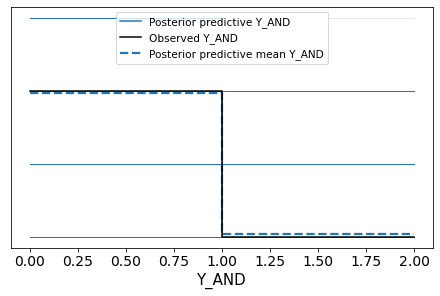

In [3]:
### Fitting Bayesian Logistic Regression to simulate AND_GATE

with pm.Model() as AND_GATE:
    b_AND = pm.Normal('b_AND',0,np.sqrt(1000))
    x1_AND = pm.Normal('x1_AND',0,np.sqrt(1000))
    x2_AND = pm.Normal('x2_AND',0,np.sqrt(1000))
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(b_AND+x1_AND*input_df['x1']+x2_AND*input_df['x2']))
    
    with AND_GATE:
    #fit the data 
        observed=pm.Bernoulli("Y_AND", p, observed=input_df['Y_AND'])
        # start=pm.find_MAP()
        # step=pm.Metropolis()
    
    #samples from posterior distribution 
        trace=pm.sample(25000)
        burned_trace=trace[15000:]
        ppc = pm.sample_posterior_predictive(
        burned_trace, var_names=["b_AND", "x1_AND", "x2_AND", "Y_AND"], random_seed=42
    )
        
idata = az.from_pymc3(burned_trace, posterior_predictive=ppc)
az.plot_ppc(idata);

In [4]:
coeffs=['b_AND', 'x1_AND','x2_AND']
coeffs_value = []

final_coeffs = []

for item in coeffs:
    coeffs_value.append(burned_trace[item].mean())

final_coeffs = final_coeffs + coeffs_value

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1933cdf908>,
      dtype=object)

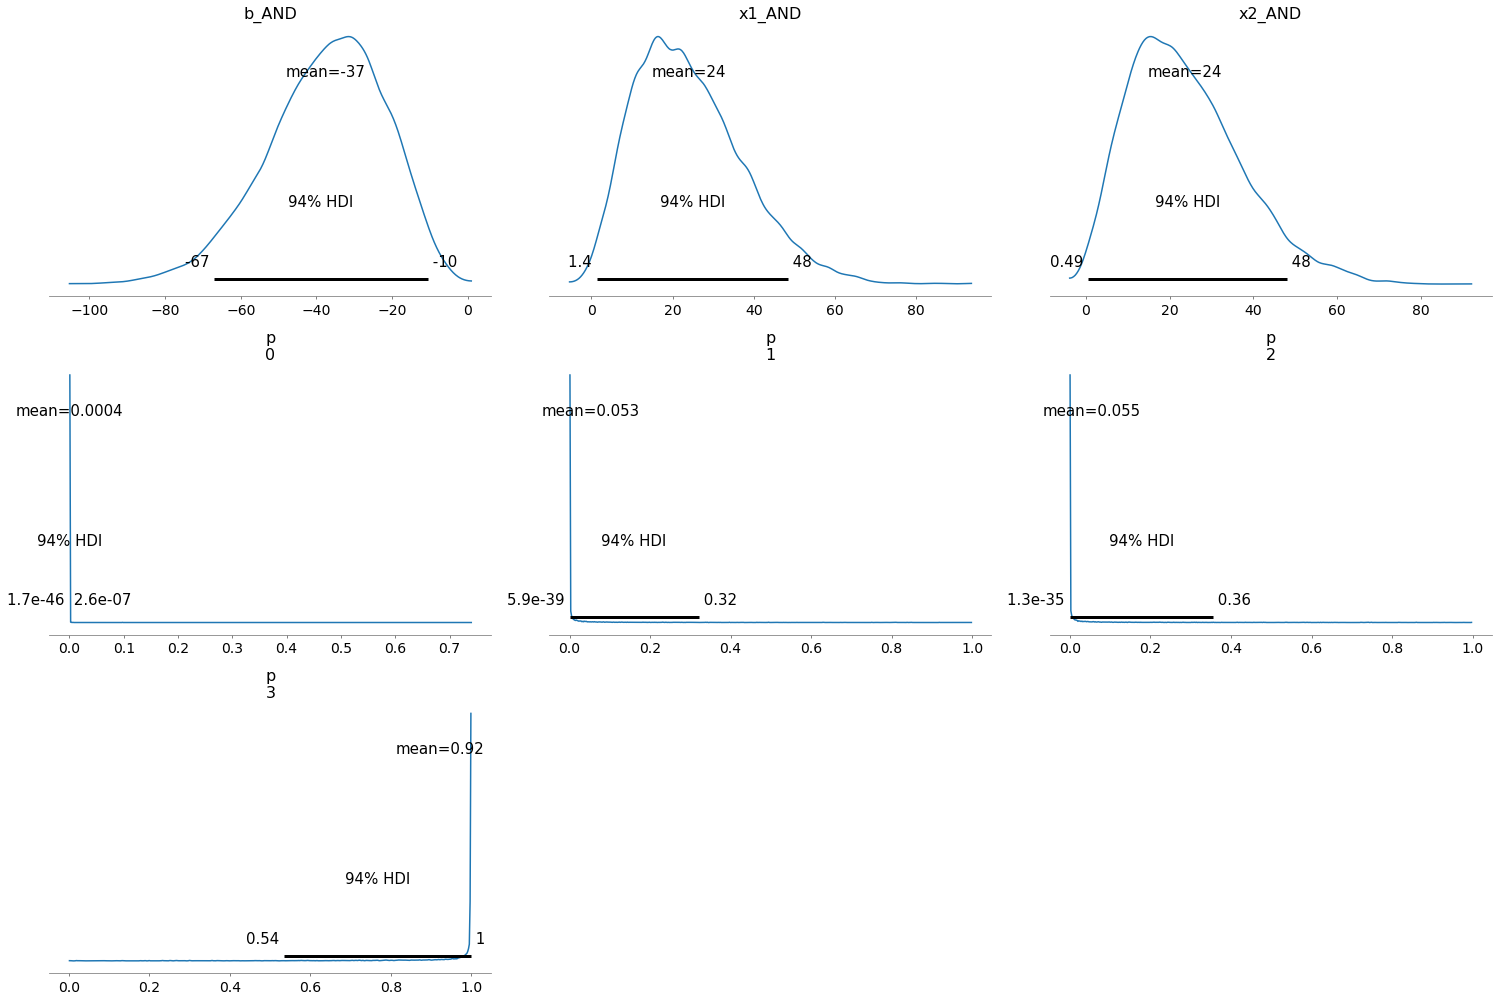

In [5]:
#### Plot of posterior for AND_GATE

pm.plot_posterior(burned_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


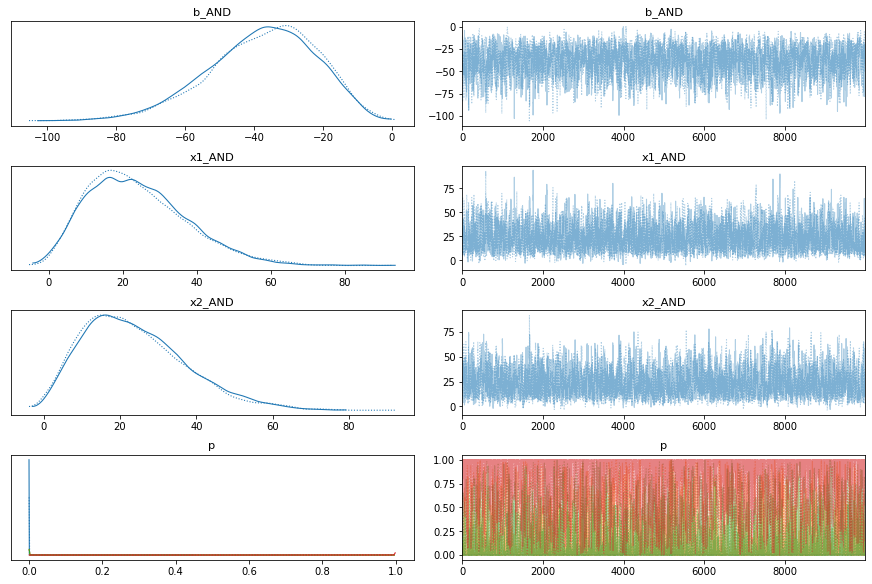

In [6]:
##### Trace plot for AND_GATE

pm.traceplot(burned_trace)
plt.show()

In [7]:
### Define deterministic AND GATE

def AND_det(num1,num2):
    logit = final_coeffs[0] + final_coeffs[1]*num1 + final_coeffs[2]*num2
    return int(np.rint(np.exp(logit)/(1+np.exp(logit))))


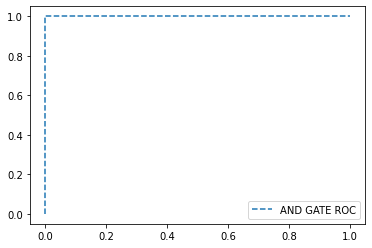

In [8]:
#### MODEL FIT OF AND GATE

prediction = [AND_det(0,0),AND_det(0,1),AND_det(1,0),AND_det(1,1)]
fpr, tpr, thresholds = roc_curve(input_df['Y_AND'], prediction)
plt.plot(fpr, tpr, linestyle='--', label='AND GATE ROC')
plt.legend(loc='best')


In [9]:
######### AUC FOR AND GATE ########

auc = roc_auc_score(input_df['Y_AND'], prediction)
print('AUC: %.3f' % auc)

AUC: 1.000


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x2_OR, x1_OR, b_OR]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 44 seconds.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


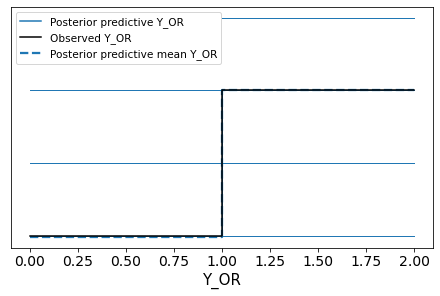

In [10]:
with pm.Model() as OR_GATE:
    b_OR = pm.Normal('b_OR',0,np.sqrt(1000))
    x1_OR = pm.Normal('x1_OR',0,np.sqrt(1000))
    x2_OR = pm.Normal('x2_OR',0,np.sqrt(1000))
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(b_OR+x1_OR*input_df['x1']+x2_OR*input_df['x2']))
    
    with OR_GATE:
    #fit the data 
        observed=pm.Bernoulli("Y_OR", p, observed=input_df['Y_OR'])
        # start=pm.find_MAP()
        # step=pm.Metropolis()
    
    #samples from posterior distribution 
        trace=pm.sample(25000)
        burned_trace=trace[15000:]

        ppc = pm.sample_posterior_predictive(
        burned_trace, var_names=["b_OR", "x1_OR", "x2_OR", "Y_OR"], random_seed=42
    )
        
idata = az.from_pymc3(burned_trace, posterior_predictive=ppc)
az.plot_ppc(idata);


In [11]:
coeffs=['b_OR', 'x1_OR','x2_OR']

coeffs_name = []
coeffs_value = []

for item in coeffs:
    coeffs_value.append(burned_trace[item].mean())

final_coeffs = final_coeffs + coeffs_value


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19310e7978>,
      dtype=object)

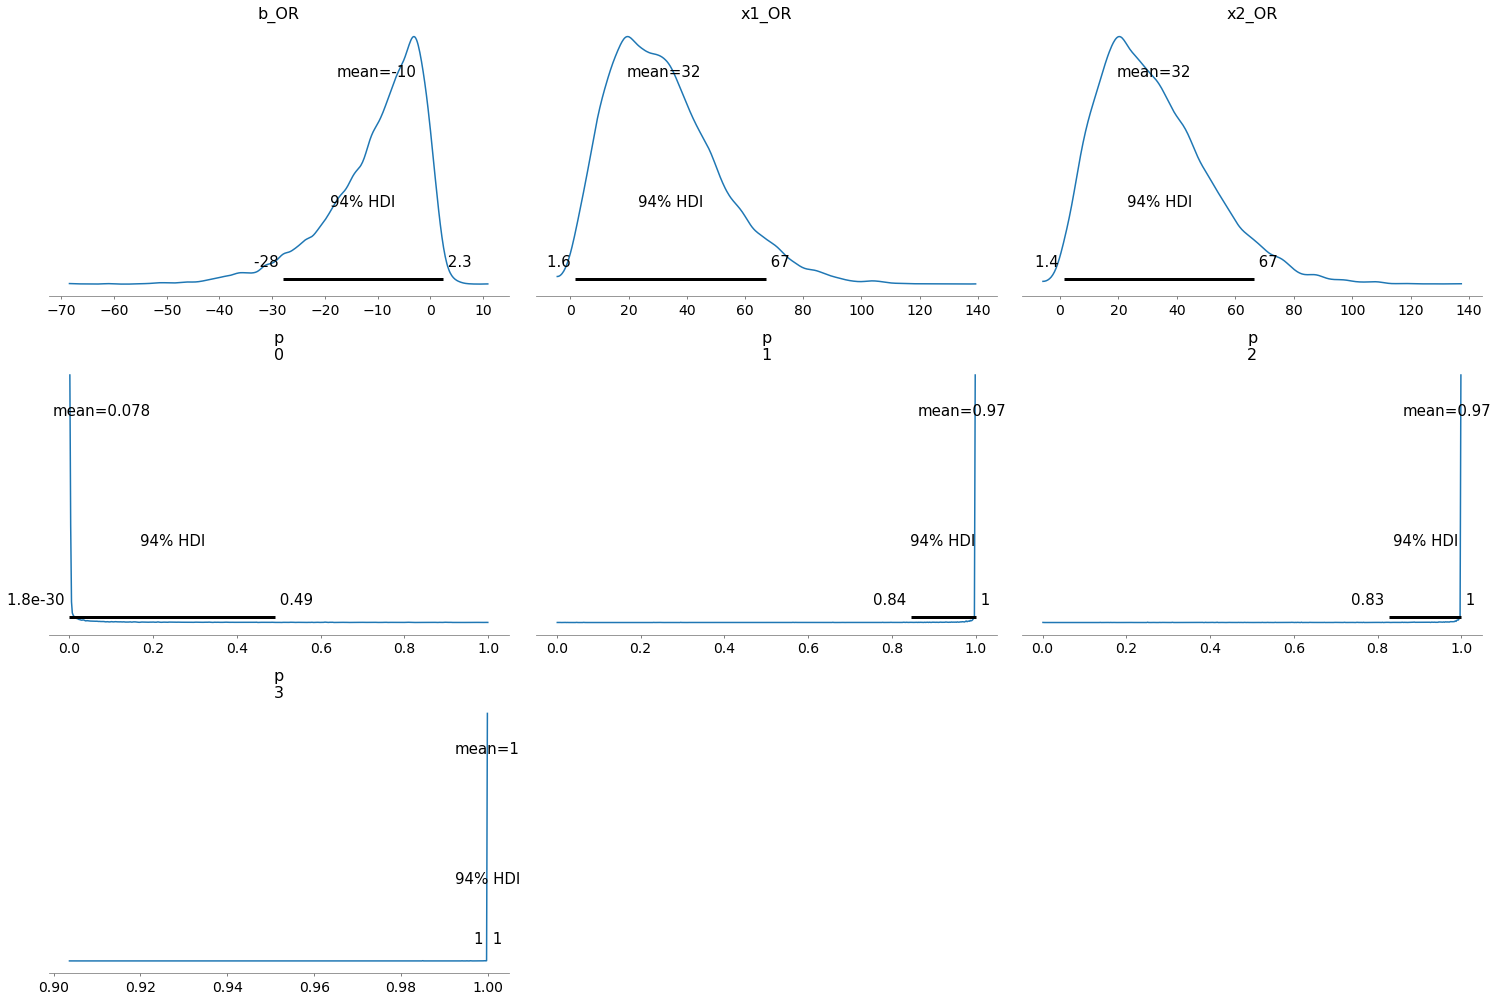

In [12]:
#### Plot of posterior for OR_GATE

pm.plot_posterior(burned_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


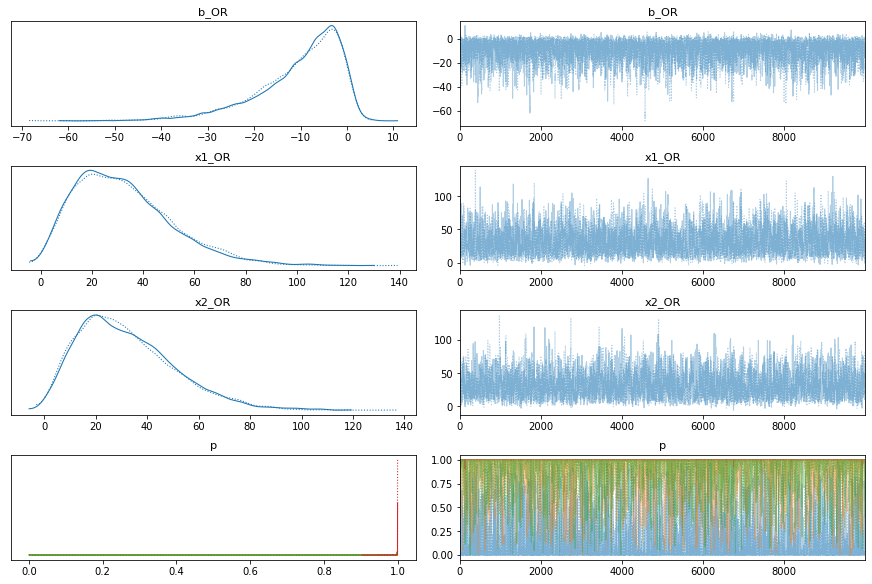

In [13]:
##### Trace plot for OR_GATE

pm.traceplot(burned_trace)
plt.show()

In [14]:
### Define deterministic OR GATE

def OR_det(num1,num2):
    logit = final_coeffs[3] + final_coeffs[4]*num1 + final_coeffs[5]*num2
    return int(np.rint(np.exp(logit)/(1+np.exp(logit))))


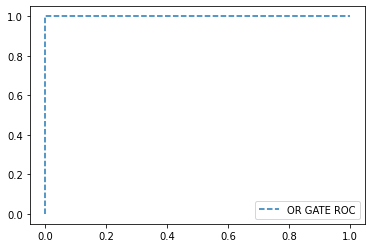

In [15]:
#### MODEL FIT OF AND GATE

prediction = [OR_det(0,0),OR_det(0,1),OR_det(1,0),OR_det(1,1)]
fpr, tpr, thresholds = roc_curve(input_df['Y_OR'], prediction)
plt.plot(fpr, tpr, linestyle='--', label='OR GATE ROC')
plt.legend(loc='best')

In [16]:
######### AUC FOR OR GATE ########

auc = roc_auc_score(input_df['Y_OR'], prediction)
print('AUC: %.3f' % auc)

AUC: 1.000


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x2_NAND, x1_NAND, b_NAND]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 57 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


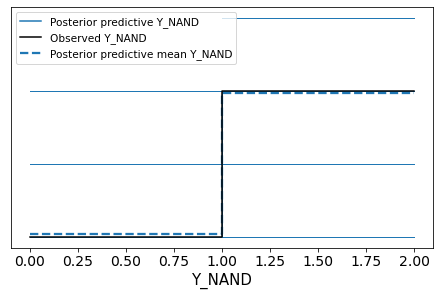

In [17]:
with pm.Model() as NAND_GATE:
    b_NAND = pm.Normal('b_NAND',0,np.sqrt(1000))
    x1_NAND = pm.Normal('x1_NAND',0,np.sqrt(1000))
    x2_NAND = pm.Normal('x2_NAND',0,np.sqrt(1000))
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(b_NAND+x1_NAND*input_df['x1']+x2_NAND*input_df['x2']))
    
    with NAND_GATE:
    #fit the data 
        observed=pm.Bernoulli("Y_NAND", p, observed=input_df['Y_NAND'])
        # start=pm.find_MAP()
        # step=pm.Metropolis()
    
    #samples from posterior distribution 
        trace=pm.sample(25000)
        burned_trace=trace[15000:]

        ppc = pm.sample_posterior_predictive(
        burned_trace, var_names=["b_NAND", "x1_NAND", "x2_NAND", "Y_NAND"], random_seed=42
    )
        
idata = az.from_pymc3(burned_trace, posterior_predictive=ppc)
az.plot_ppc(idata);




In [18]:
coeffs=['b_NAND', 'x1_NAND','x2_NAND']
coeffs_name = []
coeffs_value = []

for item in coeffs:
    coeffs_value.append(burned_trace[item].mean())

final_coeffs = final_coeffs + coeffs_value


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19322905f8>,
      dtype=object)

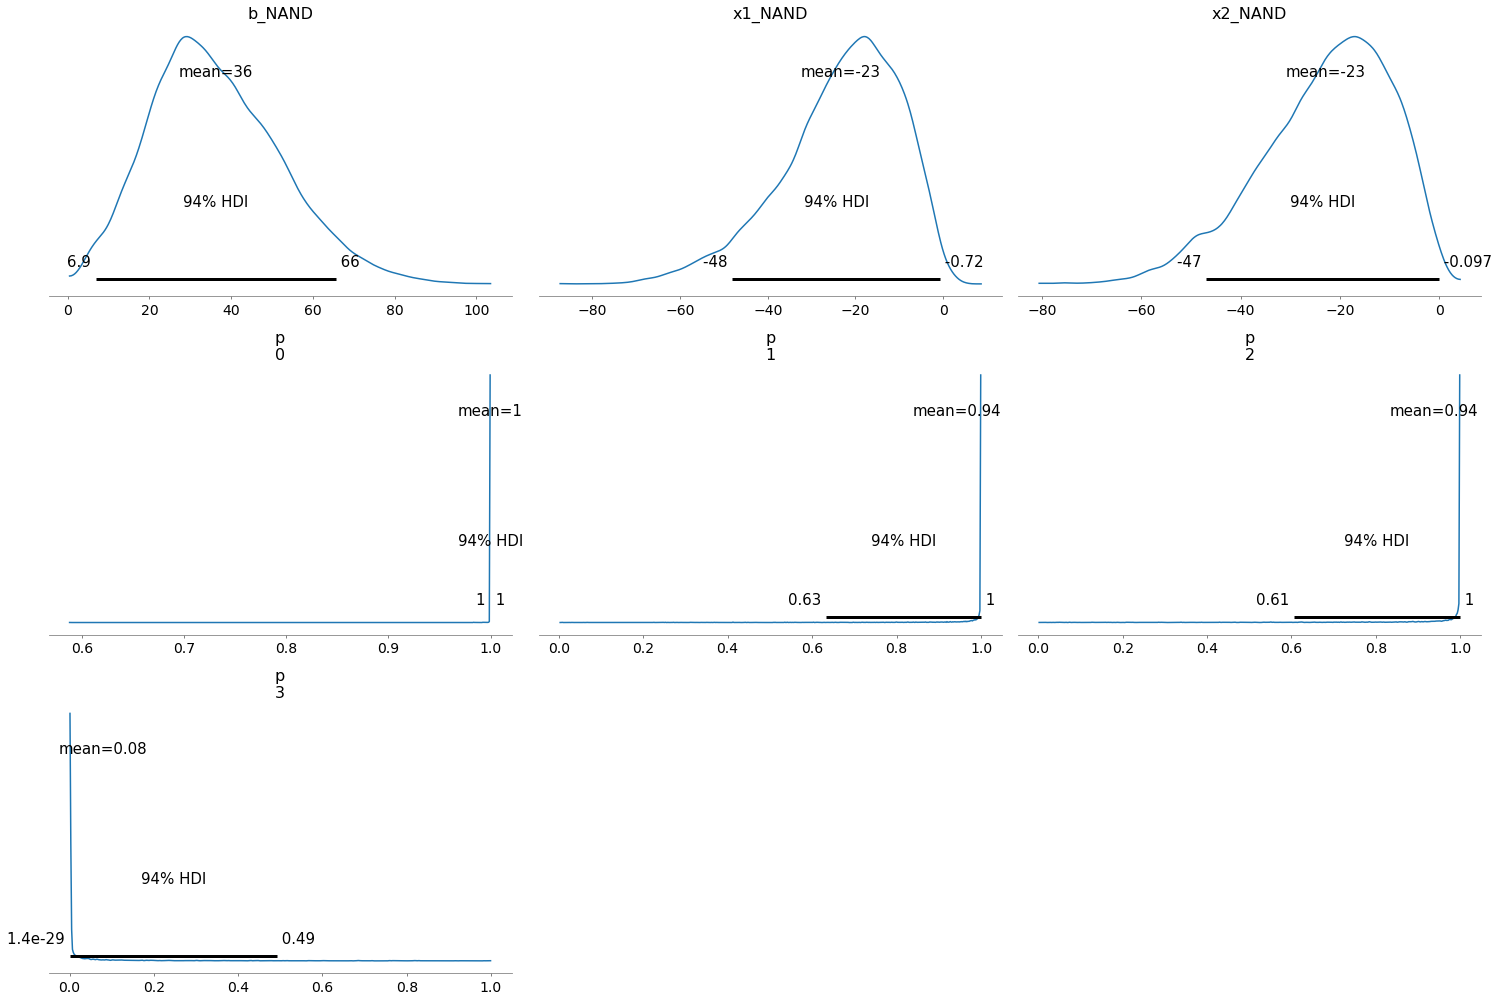

In [19]:
#### Plot of posterior for NAND_GATE

pm.plot_posterior(burned_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


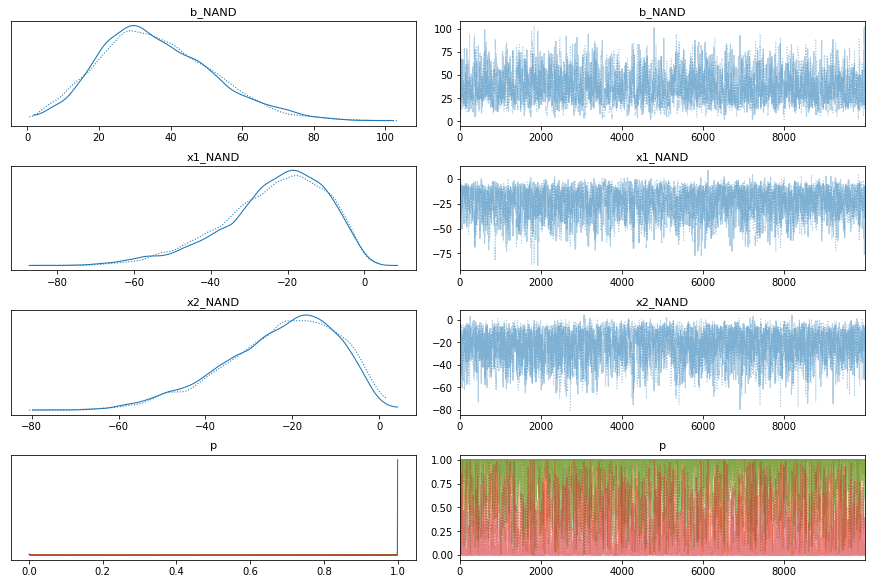

In [20]:
##### Trace plot for NAND_GATE

pm.traceplot(burned_trace)
plt.show()

In [21]:
### Define deterministic NAND GATE

def NAND_det(num1,num2):
    logit = final_coeffs[6] + final_coeffs[7]*num1 + final_coeffs[8]*num2
    return int(np.rint(np.exp(logit)/(1+np.exp(logit))))

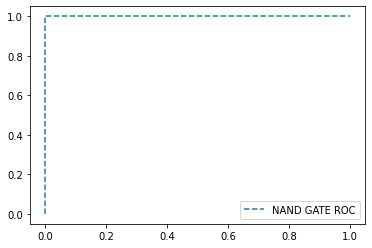

In [22]:
#### MODEL FIT OF NAND GATE

prediction = [NAND_det(0,0),NAND_det(0,1),NAND_det(1,0),NAND_det(1,1)]
fpr, tpr, thresholds = roc_curve(input_df['Y_NAND'], prediction)
plt.plot(fpr, tpr, linestyle='--', label='NAND GATE ROC')
plt.legend(loc='best')

In [23]:
######### AUC FOR NAND GATE ########

auc = roc_auc_score(input_df['Y_NAND'], prediction)
print('AUC: %.3f' % auc)

AUC: 1.000


In [24]:
#### Define brute force other gates and a full adder

def XOR_det(num1,num2):
    y1 = OR_det(num1,num2)
    y2 = NAND_det(num1,num2)
    return AND_det(y1,y2) 

def full_adder(num1,num2,C):
    s1 = XOR_det(num1,num2)
    summ = XOR_det(s1,C)
    c1 = AND_det(C,s1)
    c2 = AND_det(num1,num2)
    cfin = OR_det(c1,c2)
    return [cfin,summ]

In [25]:
############## Define N bit adder utilizing cascading of full bit adders ###########

def addition(num1,num2):
    num_adders = max(len(bin(num1)[2:]),len(bin(num2)[2:]))
    form = '{0:0' + str(num_adders) + 'b}'
    xb1 = form.format(num1)
    xb2 = form.format(num2)
    C = 0
    sum_val = []
    for i in range(num_adders):
        C,s = full_adder(int(xb1[num_adders-i-1]),int(xb2[num_adders-i-1]),int(C))
        sum_val.append(s)
    
    final_sum = [C] + sum_val[::-1]
    
    final_sum = [str(i) for i in final_sum]
    
    final_sum = int("".join(final_sum),2)
    
    return final_sum

In [26]:
num1 = int(input("Please enter first whole number you want to sum: "))
num2 = int(input("Please enter second whole number you want to sum: "))

print('The sum of', num1, 'and', num2, 'performed using Bayesian Logististic Regression based N bit adder is', addition(num1,num2))

Please enter first whole number you want to sum: 3
Please enter second whole number you want to sum: 4
The sum of 3 and 4 performed using Bayesian Logististic Regression based N bit adder is 7
